In [5]:
!pip install ipython-autotime
%load_ext autotime  

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.53 s


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 11 ms


In [7]:
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from random import random
from skimage.transform import rescale, resize, downscale_local_mean
import time


def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

def class_acc(pred, gt):
    """
    Return classification accuracy
    """
    
    pred = pred.reshape(pred.size)
    gt = gt.reshape(gt.size)
    true_class = np.count_nonzero(pred==gt)

    return true_class/gt.size

time: 705 ms


In [8]:
# Load data

# Test data
datadict = unpickle('/content/drive/My Drive/Data/cifar-10-python.tar/cifar-10-batches-py/test_batch')

X = datadict["data"]
Y = datadict["labels"]

X_test = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y_test = np.array(Y)

#Training data
X_train = np.zeros((50000, 32, 32, 3))
Y_train = np.zeros(50000)
for i in range (5):
    filename = '/content/drive/My Drive/Data/cifar-10-python.tar/cifar-10-batches-py/data_batch_' + str(i+1)
    datatrain = unpickle(filename)
    x_train = datatrain["data"]
    y_train = datatrain["labels"]
    x_train = x_train.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    y_train = np.array(y_train)

    X_train[10000*i : 10000*(i+1), :, :, :] = x_train
    Y_train[10000*i : 10000*(i+1)] = y_train

time: 4.48 s


In [9]:
X_train = X_train.astype("uint8")
# X_train.dtype

time: 271 ms


# Exercise 1

In [10]:
# Training model

def cifar10_color(X):
    return np.mean(X, axis=(1,2))

def cifar10_naivebayes_learn(Xf, Y):
    mu = np.zeros((10, 3))
    sigma = np.zeros((10, 3))
    p = np.zeros(10)
    
    for c in range(10):
        x_class = Xf[Y == c, :]
        print(x_class)
        mu[c,:] = np.mean(x_class, axis=0)
        sigma[c,:] = np.std(x_class, axis=0)
        p[c] = x_class.shape[0]/Xf.shape[0]

    return mu, sigma, p
    
def cifar10_classiﬁer_naivebayes(x, mu, sigma, p): 
    red = np.mean(x[:,:, 0])
    green = np.mean(x[:,:, 1])
    blue = np.mean(x[:,:, 2])

    class_prob = np.zeros(10)
    for c in range(10):   
        p_red = stats.norm.pdf(red, mu[c, 0], sigma[c, 0])
        p_green = stats.norm.pdf(green, mu[c, 1], sigma[c, 1])
        p_blue = stats.norm.pdf(blue, mu[c, 2], sigma[c, 2])
        
        class_prob[c] = p_red * p_green * p_blue * p[c]
    
    return np.argmax(class_prob)

time: 19.3 ms


In [11]:
Xf = cifar10_color(X_train)

time: 1.12 s


In [12]:
mu, sigma, p = cifar10_naivebayes_learn(Xf, Y_train)

[[147.90625    148.65234375 149.25488281]
 [133.91992188 124.71875    120.66113281]
 [142.69726562 120.56445312  65.90625   ]
 ...
 [161.39746094 146.61132812 131.5       ]
 [113.70605469 109.92773438 100.88378906]
 [150.58007812 156.07226562 158.22460938]]
[[ 92.02148438 102.40039062 116.00292969]
 [142.44042969  70.78027344  57.77832031]
 [ 96.9140625  100.22851562  96.49414062]
 ...
 [119.859375   136.49609375 130.01171875]
 [162.17480469 168.83398438 177.32128906]
 [138.75292969 129.59667969 127.29101562]]
[[120.53125    152.91601562  85.37792969]
 [ 79.76074219  72.46191406  75.79785156]
 [140.10742188 124.43847656 117.75488281]
 ...
 [122.15527344 103.52441406  85.5703125 ]
 [158.11132812 156.56054688 153.2421875 ]
 [133.1875     147.11132812 174.2421875 ]]
[[ 78.13671875  71.56347656  61.79589844]
 [ 97.328125    87.96582031  81.48730469]
 [214.31054688  38.91796875  58.74414062]
 ...
 [111.25488281  97.81054688  72.20703125]
 [ 46.0625      38.78515625  30.63574219]
 [151.85937

In [13]:
pred = np.zeros(len(X_test))
for i in range(len(X_test)):
    pred[i] = cifar10_classiﬁer_naivebayes(X_test[i,:,:,:], mu, sigma, p)

time: 30.7 s


In [14]:
class_acc(pred, Y_test)

0.1947

time: 5.71 ms


# Exercise 2

In [15]:
# Pre-processing data
def cifar10_color_resize(X, k=1):
    return resize(X, (X.shape[0], k, k, 3))

# Training model

def cifar_10_bayes_learn(Xf, Y):
    num_features = Xf.shape[1]
    mu = np.zeros((10, num_features))
    sigma = np.zeros((10, num_features, num_features))
    p = np.zeros(10)

    for c in range(10):
        x_class = Xf[Y == c, :]
        mu[c,:] = np.mean(x_class, axis=0)
        sigma[c,:] = np.cov(x_class.T)
        p[c] = x_class.shape[0]/Xf.shape[0]

    return mu, sigma, p


def cifar10_classiﬁer_bayes(x, mu, sigma, p):   
    pred = np.zeros((x.shape[0], 10))
    for c in range(10):  
        pred[:, c] = stats.multivariate_normal.logpdf(x, mean=mu[c, :], cov=sigma[c, :, :]) * p[c] 
    return(np.argmax(pred, axis=1))


time: 18.5 ms


In [16]:
Xf_2 = cifar10_color_resize(X_train)
X_test_resize = cifar10_color_resize(X_test).reshape(X_test.shape[0], -1)
mu, sigma, p = cifar_10_bayes_learn(Xf_2.reshape(Xf_2.shape[0], -1), Y_train)

time: 30.5 s


In [17]:
predict = cifar10_classiﬁer_bayes(X_test_resize, mu, sigma, p)
print(class_acc(predict, Y_test))

0.2479
time: 23.9 ms


# Exercise 3


In [18]:
MAX_SCALE = 6
accruacy_on_scale = []
TRAINING_SIZE = X_train.shape[0]
TEST_SIZE = X_test.shape[0]

for scale in range(MAX_SCALE):
    #Preprocessing data
    start_time = time.time()
    k = 2**scale
    Xf_3 = cifar10_color_resize(X_train, k)
    X_test_resize_3 = cifar10_color_resize(X_test, k).reshape(TEST_SIZE, -1)
    print("Preprocessing in %s seconds" % (time.time() - start_time))

    # Training
    start_time = time.time()
    mu_3, sigma_3, p_3 = cifar_10_bayes_learn(Xf_3.reshape(TRAINING_SIZE, -1), Y_train)
    
    # Predicting
    predict = cifar10_classiﬁer_bayes(X_test_resize_3, mu_3, sigma_3, p_3)
    
    acc = class_acc(predict, Y_test)
    accruacy_on_scale.append(acc)
    print(f"{k}x{k}-image ->", acc)
    
    # End running time
    print("run time in seconds:",(time.time() - start_time))

Preprocessing in 30.24412512779236 seconds
1x1-image -> 0.2479
run time in seconds: 0.01532435417175293
Preprocessing in 14.86063838005066 seconds
2x2-image -> 0.3105
run time in seconds: 0.03487849235534668
Preprocessing in 7.75932502746582 seconds
4x4-image -> 0.4022
run time in seconds: 0.1116037368774414
Preprocessing in 6.878480911254883 seconds
8x8-image -> 0.4173
run time in seconds: 1.0681490898132324
Preprocessing in 12.997158527374268 seconds
16x16-image -> 0.4346
run time in seconds: 7.919282913208008
Preprocessing in 44.12567710876465 seconds
32x32-image -> 0.3623
run time in seconds: 170.46650052070618
time: 4min 56s


[0.2479, 0.3105, 0.4022, 0.4173, 0.4346, 0.3623]


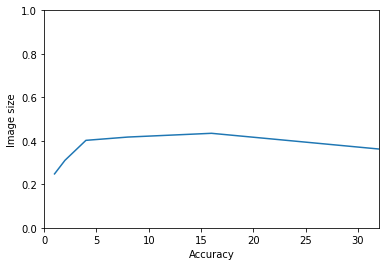

time: 153 ms


In [26]:
a = np.array([2**x for x in range(MAX_SCALE)])
print(accruacy_on_scale)
plt.plot(a,accruacy_on_scale)
plt.axis([0,2**(MAX_SCALE-1),0,1])
plt.xlabel('Accuracy')
plt.ylabel('Image sizex')
plt.show()